# Solar energy - Predictions for one MONTH & one STATION

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 300

import warnings
warnings.filterwarnings("ignore")

## Data preparation

In [2]:
path = "../../../datasets/_classified/kaggle/"
df = pd.read_csv(path + "solar_generation_by_station.csv")

In [3]:
def add_date_time(_df):
    "Returns a DF with two new cols : the time and hour of the day"
    t = pd.date_range(start='1/1/1986', periods=_df.shape[0], freq = 'H')
    t = pd.DataFrame(t)
    _df = pd.concat([_df, t], axis=1)
    _df.rename(columns={ _df.columns[-1]: "time" }, inplace = True)
    _df['year'] = _df['time'].dt.year
    _df['month'] = _df['time'].dt.month
    _df['week'] = _df['time'].dt.weekofyear
    _df['day'] = _df['time'].dt.dayofyear    
    _df['hour'] = _df['time'].dt.hour
    return _df

In [4]:
df = add_date_time(df)
df = df[~df.year.isin([1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016])]

# keeping only values for one country for the predictions
df = df[['FR10', 'year', 'month', 'week', 'day', 'hour', 'time']]
df.head(2)

,FR10,year,month,week,day,hour,time
0,0.0,1986,1,1,1,0,1986-01-01 00:00:00
1,0.0,1986,1,1,1,1,1986-01-01 01:00:00


In [5]:
df.shape

(201480, 7)

In [6]:
# train data for 10 years
train_data = df[-24*365*10:-24*31]

# test data = last month of records / 2015
test_data = df[-24*31:]

# Model Training

## metric

As previously seen during the exploratory data analysis, the dataset is clean : there isn't any outlier, any duplicated line ou missing values. The Root Mean Squared Error is therefore the best metric.

We'll try several models of regression to make prediction of the energy efficiency. In order to find which model is the best we'll compare:
- results between predictions on the train & test datasets: how will models be able to generalize ?
- reuslts between various models

In [7]:
from sklearn.metrics import mean_squared_error
model_instances, model_names, rmse_train, rmse_test = [], [], [], []

# from sklearn.model_selection import train_test_split

def plot_scores():
    df_score = pd.DataFrame({'model_names' : model_names,
                             'rmse_train' : rmse_train,
                             'rmse_test' : rmse_test})
    df_score = pd.melt(df_score, id_vars=['model_names'], value_vars=['rmse_train', 'rmse_test'])

    plt.figure(figsize=(12, 10))
    sns.barplot(y="model_names", x="value", hue="variable", data=df_score)
    plt.show()

## baseline

use the hourly mean of 10 years of records for specific hours & days 

In [8]:
x_train, y_train = train_data.drop(columns=['time']), train_data['FR10']
x_test, y_test = test_data.drop(columns=['time']), test_data['FR10']

In [9]:
def mean_df(d, h):
    "return the hourly mean of a specific day of the year"
    res = x_train[(x_train['day'] == d) & (x_train['hour'] == h)]['FR10'].mean()
    return res

    # examples 
    #df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
    # x_train[(x_train['day'] == x['day']) & (x_train['hour'] == x['hour'])]['FR10'].mean()

In [10]:
#x_train['pred'] = x_train.apply(lambda x: mean_df(x.day, x.hour), axis=1)
x_test['pred'] = x_test.apply(lambda x: mean_df(x.day, x.hour), axis=1)

In [11]:
x_test.head()

,FR10,year,month,week,day,hour,pred
262224,0.0,2015,12,49,335,0,0.0
262225,0.0,2015,12,49,335,1,0.0
262226,0.0,2015,12,49,335,2,0.0
262227,0.0,2015,12,49,335,3,0.0
262228,0.0,2015,12,49,335,4,0.0


In [12]:
model_names.append("base_line")
rmse_train.append(np.sqrt(mean_squared_error(x_train['FR10'], x_train['FR10']))) # a modifier en pred
rmse_test.append(np.sqrt(mean_squared_error(x_test['FR10'], x_test['pred'])))

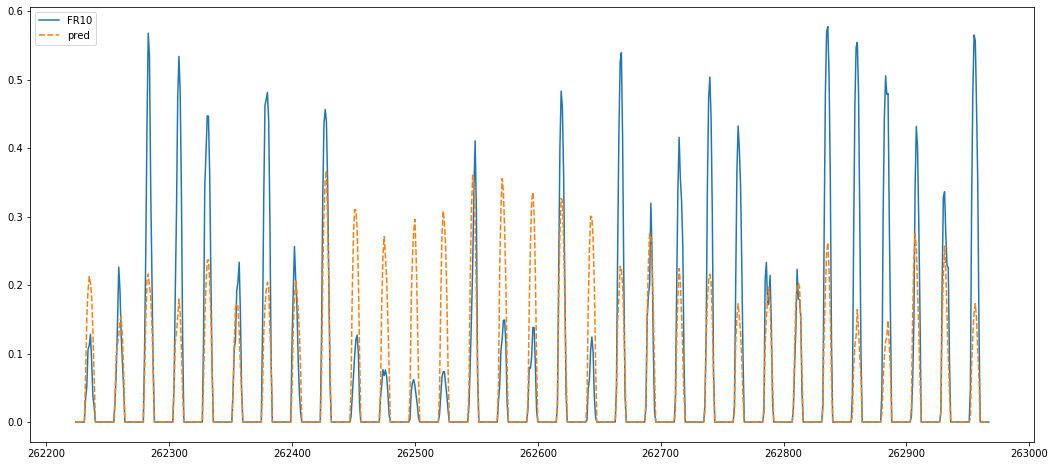

In [13]:
plt.figure(figsize=(18, 8))
sns.lineplot(data=x_test[['FR10', 'pred']])

## basic regression models

In [14]:
X_train, y_train = train_data[['month', 'week', 'day', 'hour']], train_data['FR10']
X_test, y_test = test_data[['month', 'week', 'day', 'hour']], test_data['FR10']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((86856, 4), (86856,), (744, 4), (744,))

In [15]:
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

import xgboost as xgb
import lightgbm as lgbm

In [16]:
def get_rmse(reg, model_name):
    """Print the score for the model passed in argument and retrun scores for the train/test sets"""
    
    y_train_pred, y_pred = reg.predict(X_train), reg.predict(X_test)
    rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_pred))
    print(model_name, f'\t - RMSE on Training  = {rmse_train:.2f} / RMSE on Test = {rmse_test:.2f}')
    
    return rmse_train, rmse_test

In [17]:
# list of all the basic models used at first
model_list = [
    LinearRegression(), Lasso(), Ridge(), ElasticNet(),
    RandomForestRegressor(), GradientBoostingRegressor(), ExtraTreesRegressor(),
    xgb.XGBRegressor(), lgbm.LGBMRegressor()
             ]

# creation of list of names and scores for the train / test
model_names.extend([str(m)[:str(m).index('(')] for m in model_list])


# fit and predict all models
for model, name in zip(model_list, model_names):
    model.fit(X_train, y_train)
    sc_train, sc_test = get_rmse(model, name)
    rmse_train.append(sc_train)
    rmse_test.append(sc_test)

base_line 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
LinearRegression 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
Lasso 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
Ridge 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
ElasticNet 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10
RandomForestRegressor 	 - RMSE on Training  = 0.11 / RMSE on Test = 0.09
GradientBoostingRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10
[14:58:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
ExtraTreesRegressor 	 - RMSE on Training  = 0.11 / RMSE on Test = 0.09
XGBRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10


In [18]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred = pd.DataFrame(gbr.predict(X_test))

In [19]:
y_test = pd.DataFrame(y_test)
y_test['pred'] = y_pred.values
y_test.head()

,FR10,pred
262224,0.0,-0.013495
262225,0.0,-0.013495
262226,0.0,-0.013495
262227,0.0,-0.013495
262228,0.0,-0.013495


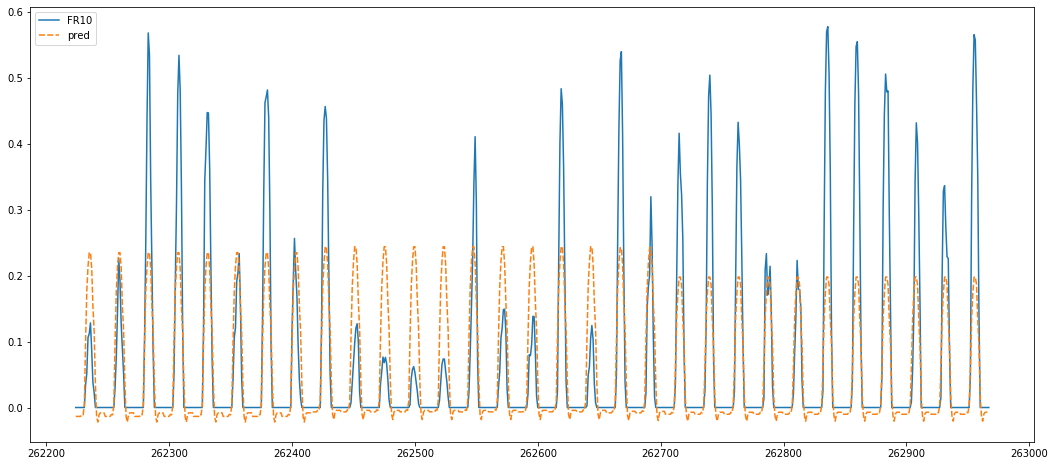

In [20]:
plt.figure(figsize=(18, 8))
sns.lineplot(data=y_test)

## with prophet a facebook lib for time series

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [21]:
# reload data : same as before
df = pd.read_csv(path + "solar_generation_by_station.csv")
df = add_date_time(df)
#df = df[~df.year.isin([1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016])]

In [22]:
data = df[['time', 'FR10']]
data = data.rename(columns={"time": "ds", "FR10": "y"})
#train_data = data[:-24*365]
#test_data = data[-24*365:]

# train data for 10 years
train_data = data[-24*365*10:-24*31]

# test data = last month of records / 2015
test_data = data[-24*31:]

In [23]:
from fbprophet import Prophet

prophet_model = Prophet()

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [24]:
prophet_model.fit(train_data)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [25]:
test_data.tail()

,ds,y
262963,2015-12-31 19:00:00,0.0
262964,2015-12-31 20:00:00,0.0
262965,2015-12-31 21:00:00,0.0
262966,2015-12-31 22:00:00,0.0
262967,2015-12-31 23:00:00,0.0


In [26]:
#y_train_pred = prophet_model.predict(train_data)

In [27]:
forecast = prophet_model.predict(test_data)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['FR10'] = test_data['y'].values
forecast.tail()

,ds,yhat,yhat_lower,yhat_upper,FR10
739,2015-12-31 19:00:00,-0.082307,-0.238453,0.071316,0.0
740,2015-12-31 20:00:00,-0.077637,-0.223132,0.072849,0.0
741,2015-12-31 21:00:00,-0.071139,-0.223808,0.077104,0.0
742,2015-12-31 22:00:00,-0.073426,-0.238038,0.088120,0.0
743,2015-12-31 23:00:00,-0.080386,-0.236773,0.065686,0.0


In [28]:
model_names.extend(["prophet", "prophet_lower", "prophet_upper"])

rmse_train.extend([0, 0, 0])

rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat'])))
rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat_lower'])))
rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat_upper'])))

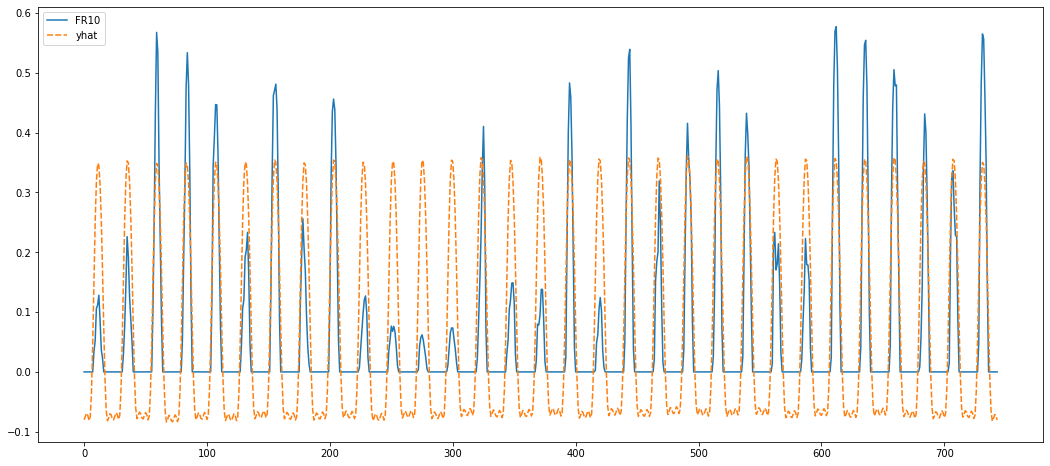

In [29]:
plt.figure(figsize=(18, 8))
sns.lineplot(data=forecast[['FR10', 'yhat']])

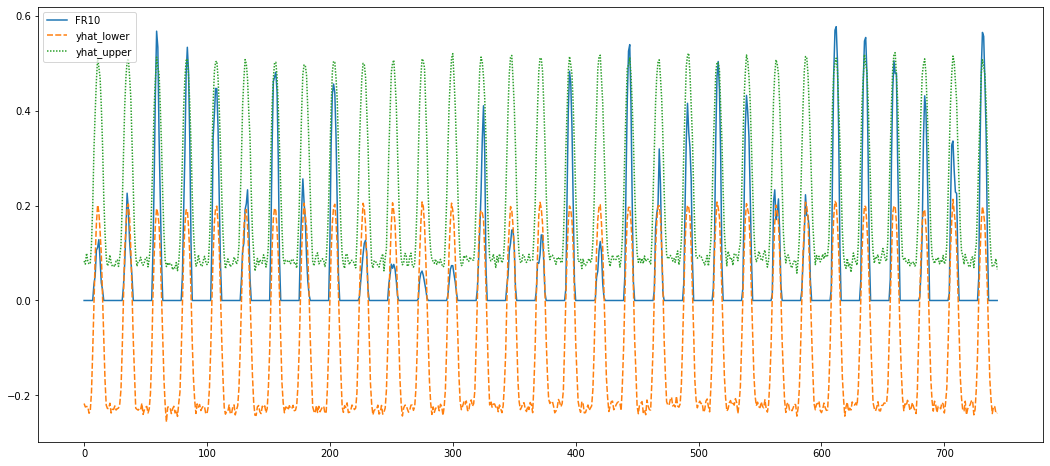

In [30]:
plt.figure(figsize=(18, 8))
sns.lineplot(data=forecast[['FR10', 'yhat_lower', 'yhat_upper']])

# Conclusion 

In [31]:
len(model_names), len(rmse_train), len(rmse_test)

(13, 13, 13)

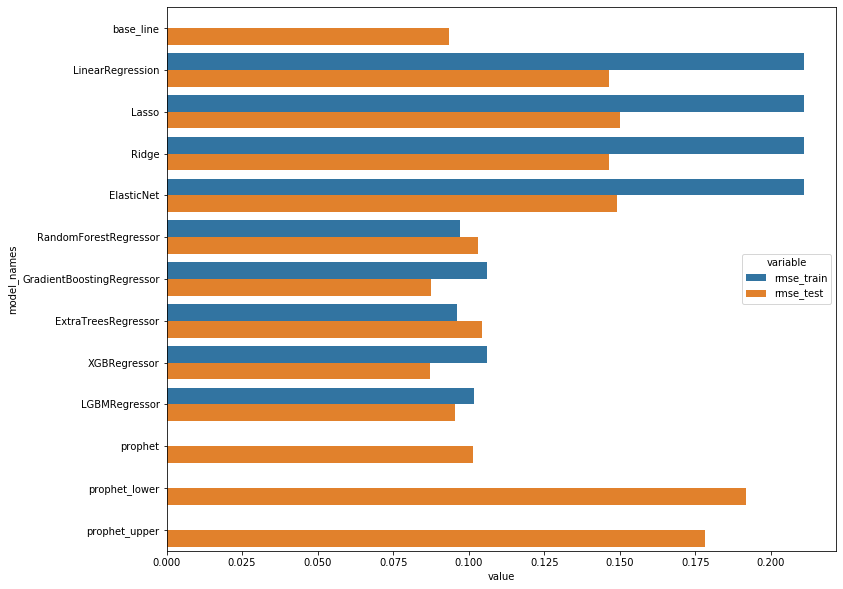

In [32]:
plot_scores()

- An RMSE below 0.1 is quite good compared to values ranging from 0 to less than 1.
- Finally only few models are better than the baseline, but not that better.
- Only the linear regression and ridge get better when we deal with months, weeks, days & hours as categorical features with "get dummies" pandas method.
- Facebook lib's prophet is finally not that effective but the forecast of a whole year is probably a difficult goal.